In [2]:
from simulation import *
from aesthetics import *
from models import *
from data import *
from analysis import *

import glob
import os as os
import re as re
import pandas as pd

%reload_ext autoreload
%autoreload 2
%matplotlib inline
mpl.rc('text', usetex=True)
cmap = sns.color_palette("Paired", 10)

# Question: do the angles in HIVP show significant flux when the catalytic rate is increased?

In [13]:
hiv_dir = '../../md-data/hiv-protease/'
hiv_unbound_files = sorted(glob.glob(hiv_dir + '1hhp_apo/' + '*'))
names = []
for file in range(len(hiv_unbound_files)):
    name = os.path.splitext(os.path.basename(hiv_unbound_files[file]))[0]
    name = re.search('^[^_]*', name).group(0)        
    if re.search('omega*', name):
        continue
    if re.search('chi3ASN*', name):
        continue
    if re.search('chi5LYS*', name):
        continue
    names.append(name)

In [6]:
fluxes = []
for name in names:
    this = simulation(data_source='hiv_md_data')
    this.name = name
    this.cSubstrate = 10**-3
    # Let's set the HIVP catalytic rate to the same as ADK (312 per second)
    this.catalytic_rate = 312
    this.simulate()
    fluxes.append(np.mean(this.flux_u + this.flux_b))
    del this

In [8]:
max(fluxes)

5.499578752834835

In [9]:
min(fluxes)

-94.397080506754122

Okay, those aren't quite so bad. So maybe HIVP is just hampered by the slow catalytic rate.

In [17]:
def summarize_fluxes(name, concentration, data_source='hiv_md_data', catalytic_rate=None):
    this = simulation(data_source = data_source)
    this.cSubstrate = concentration
    if catalytic_rate:
        this.catalytic_rate = catalytic_rate
    this.name = name
    this.simulate()
    directional_flux = np.mean(this.flux_u + this.flux_b)
    intersurface_flux = max(abs(this.flux_ub))
    # Make all flux on each surface positive
    unbound_flux = abs(this.flux_u)
    bound_flux = abs(this.flux_b)
    # Now find the maximum on either surface
    max_unbound = max(unbound_flux)
    max_bound = max(bound_flux)
    driven_flux = max([max_unbound, max_bound])
    del this
    return directional_flux, intersurface_flux, driven_flux


In [11]:
def summarize_power_and_load(name, concentration, data_source='hiv_md_data', negative=False,
                            debug=False, catalytic_rate=None):
    this = simulation(data_source=data_source)
    this.cSubstrate = concentration
    if catalytic_rate:
        this.catalytic_rate = catalytic_rate
    this.name = name
    # The difference now, is that we're going to need to simulate with
    # an applied load.
    this.load = True
    # Initialize the applied load to be something small, and we'll increase
    # from there on out.
    slope = 0.000
    increment = 0.00001
    loads = []
    power_given_load = []
    flux_given_load = []
    while True:
        if negative:
            this.load_slope = -slope
        else:
            this.load_slope = slope
        this.simulate()
        # Bookkeeping
        flux = np.mean(this.flux_u + this.flux_b)
        power = this.load_slope * np.mean(this.flux_u + this.flux_b)
        loads.append(this.load_slope)
        flux_given_load.append(flux)
        power_given_load.append(power)
        # Now, we need to check the power trend to see if we should break
        # out of the loop.
        max_power = max(power_given_load)
        max_power_index = power_given_load.index(max_power)
        # Is the maximum power the last element?
        if max_power > power_given_load[0] and max_power > power_given_load[-1]:
            # print('Looks good. Maximum power = {} with load = {}'.format(
            #    max_power, loads[max_power_index]))
            # But let's check and make sure the power doesn't continue to increase,
            # before we break
            slope += increment
            if negative:
                this.load_slope = -slope
            else:
                this.load_slope = slope
            this.simulate()
            power = this.load_slope * np.mean(this.flux_u + this.flux_b)
            if max_power > power:
                # break
                return max_power, loads[max_power_index]
        if max_power == 0 and len(power_given_load) > 100:
            # Sometimes this happens... 
            # We should probably make a note of this too. Ugh.
            # This can happen if the maximum load that can be supported is even 
            # smaller than the increment size.
            return 0.0, 0.0
        if len(power_given_load) % 100 == 0:
            increment *= 10
        if len(power_given_load) > 1000:
            print('I give up.')
        if slope > 10:
            print('This doesn\'t make sense.')
            break
        slope += increment
    del this

In [9]:
calculation = False
df = pd.DataFrame()
if calculation:
    for concentration in np.arange(-6, 0, 1):
        print('concentration = {}'.format(concentration))
        for name in names:
            directional_flux, intersurface_flux, driven_flux = summarize_fluxes(name, concentration=10**concentration,
                                                                               data_source='hiv_md_data',
                                                                               catalytic_rate=312) 
            if directional_flux < 0:
                negative=True
            else:
                negative=False
            max_power, max_load = summarize_power_and_load(name, concentration=10**concentration, negative=negative, 
                                                           debug=False, data_source='hiv_md_data',
                                                           catalytic_rate=312)
            df = df.append(pd.DataFrame({'Concentration': concentration,
                                    'Directional flux': directional_flux,
                                    'Intersurface flux': intersurface_flux,
                                    'Driven flux': driven_flux,
                                    'File': name,
                                    'Max power': max_power,
                                    'Max load' : max_load,
                                    'ResID': re.match('.*?([0-9]+)$', name).group(1),
                                    }, index=[0]), ignore_index=True)

    df.to_pickle('hiv-high-catalytic-rate.pickle')
else:
    df = pd.read_pickle('hiv-high-catalytic-rate.pickle')

In [19]:
calculation = True
df = pd.DataFrame()
if calculation:
    for concentration in np.arange(-6, 0, 0.1):
        print('concentration = {}'.format(concentration))
        for name in names:
            directional_flux, intersurface_flux, driven_flux = summarize_fluxes(name, concentration=10**concentration,
                                                                               data_source='hiv_md_data',
                                                                               catalytic_rate=300) 
            df = df.append(pd.DataFrame({'Concentration': concentration,
                                    'Directional flux': directional_flux,
                                    'Intersurface flux': intersurface_flux,
                                    'Driven flux': driven_flux,
                                    'File': name,
                                    'ResID': re.match('.*?([0-9]+)$', name).group(1),
                                    }, index=[0]), ignore_index=True)

    df.to_pickle('hiv-high-catalytic-rate-300.pickle')

concentration = -6.0
concentration = -5.9
concentration = -5.800000000000001
concentration = -5.700000000000001
concentration = -5.600000000000001
concentration = -5.500000000000002
concentration = -5.400000000000002
concentration = -5.3000000000000025
concentration = -5.200000000000003
concentration = -5.100000000000003
concentration = -5.0000000000000036
concentration = -4.900000000000004
concentration = -4.800000000000004
concentration = -4.700000000000005
concentration = -4.600000000000005
concentration = -4.500000000000005
concentration = -4.400000000000006
concentration = -4.300000000000006
concentration = -4.200000000000006
concentration = -4.100000000000007
concentration = -4.000000000000007
concentration = -3.9000000000000075
concentration = -3.800000000000008
concentration = -3.700000000000008
concentration = -3.6000000000000085
concentration = -3.500000000000009
concentration = -3.4000000000000092
concentration = -3.3000000000000096
concentration = -3.20000000000001
concentr

In [20]:
calculation = True
df = pd.DataFrame()
if calculation:
    for concentration in np.arange(-6, 0, 0.1):
        print('concentration = {}'.format(concentration))
        for name in names:
            directional_flux, intersurface_flux, driven_flux = summarize_fluxes(name, concentration=10**concentration,
                                                                               data_source='hiv_md_data',
                                                                               catalytic_rate=200) 
            df = df.append(pd.DataFrame({'Concentration': concentration,
                                    'Directional flux': directional_flux,
                                    'Intersurface flux': intersurface_flux,
                                    'Driven flux': driven_flux,
                                    'File': name,
                                    'ResID': re.match('.*?([0-9]+)$', name).group(1),
                                    }, index=[0]), ignore_index=True)

    df.to_pickle('hiv-high-catalytic-rate-200.pickle')

concentration = -6.0
concentration = -5.9
concentration = -5.800000000000001
concentration = -5.700000000000001
concentration = -5.600000000000001
concentration = -5.500000000000002
concentration = -5.400000000000002
concentration = -5.3000000000000025
concentration = -5.200000000000003
concentration = -5.100000000000003
concentration = -5.0000000000000036
concentration = -4.900000000000004
concentration = -4.800000000000004
concentration = -4.700000000000005
concentration = -4.600000000000005
concentration = -4.500000000000005
concentration = -4.400000000000006
concentration = -4.300000000000006
concentration = -4.200000000000006
concentration = -4.100000000000007
concentration = -4.000000000000007
concentration = -3.9000000000000075
concentration = -3.800000000000008
concentration = -3.700000000000008
concentration = -3.6000000000000085
concentration = -3.500000000000009
concentration = -3.4000000000000092
concentration = -3.3000000000000096
concentration = -3.20000000000001
concentr

In [21]:
calculation = True
df = pd.DataFrame()
if calculation:
    for concentration in np.arange(-6, 0, 0.1):
        print('concentration = {}'.format(concentration))
        for name in names:
            directional_flux, intersurface_flux, driven_flux = summarize_fluxes(name, concentration=10**concentration,
                                                                               data_source='hiv_md_data',
                                                                               catalytic_rate=100) 
            df = df.append(pd.DataFrame({'Concentration': concentration,
                                    'Directional flux': directional_flux,
                                    'Intersurface flux': intersurface_flux,
                                    'Driven flux': driven_flux,
                                    'File': name,
                                    'ResID': re.match('.*?([0-9]+)$', name).group(1),
                                    }, index=[0]), ignore_index=True)

    df.to_pickle('hiv-high-catalytic-rate-100.pickle')

concentration = -6.0
concentration = -5.9
concentration = -5.800000000000001
concentration = -5.700000000000001
concentration = -5.600000000000001
concentration = -5.500000000000002
concentration = -5.400000000000002
concentration = -5.3000000000000025
concentration = -5.200000000000003
concentration = -5.100000000000003
concentration = -5.0000000000000036
concentration = -4.900000000000004
concentration = -4.800000000000004
concentration = -4.700000000000005
concentration = -4.600000000000005
concentration = -4.500000000000005
concentration = -4.400000000000006
concentration = -4.300000000000006
concentration = -4.200000000000006
concentration = -4.100000000000007
concentration = -4.000000000000007
concentration = -3.9000000000000075
concentration = -3.800000000000008
concentration = -3.700000000000008
concentration = -3.6000000000000085
concentration = -3.500000000000009
concentration = -3.4000000000000092
concentration = -3.3000000000000096
concentration = -3.20000000000001
concentr

In [23]:
calculation = True
df = pd.DataFrame()
if calculation:
    for concentration in np.arange(-6, 0, 0.1):
        print('concentration = {}'.format(concentration))
        for name in names:
            directional_flux, intersurface_flux, driven_flux = summarize_fluxes(name, concentration=10**concentration,
                                                                               data_source='hiv_md_data',
                                                                               catalytic_rate=10) 
            df = df.append(pd.DataFrame({'Concentration': concentration,
                                    'Directional flux': directional_flux,
                                    'Intersurface flux': intersurface_flux,
                                    'Driven flux': driven_flux,
                                    'File': name,
                                    'ResID': re.match('.*?([0-9]+)$', name).group(1),
                                    }, index=[0]), ignore_index=True)

    df.to_pickle('hiv-high-catalytic-rate-10.pickle')

concentration = -6.0
concentration = -5.9
concentration = -5.800000000000001
concentration = -5.700000000000001
concentration = -5.600000000000001
concentration = -5.500000000000002
concentration = -5.400000000000002
concentration = -5.3000000000000025
concentration = -5.200000000000003
concentration = -5.100000000000003
concentration = -5.0000000000000036
concentration = -4.900000000000004
concentration = -4.800000000000004
concentration = -4.700000000000005
concentration = -4.600000000000005
concentration = -4.500000000000005
concentration = -4.400000000000006
concentration = -4.300000000000006
concentration = -4.200000000000006
concentration = -4.100000000000007
concentration = -4.000000000000007
concentration = -3.9000000000000075
concentration = -3.800000000000008
concentration = -3.700000000000008
concentration = -3.6000000000000085
concentration = -3.500000000000009
concentration = -3.4000000000000092
concentration = -3.3000000000000096
concentration = -3.20000000000001
concentr

In [23]:
def plot_flux_vs_concentration(df, color=None, xmin=10**-7, xmax=10**0,
                                ymin=-10, ymax=80):
    fig = plt.figure(figsize=(6 * 1.2, 6))
    gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
    ax = plt.subplot(gs[0, 0])
    
    concentrations = []
    maximum_flux = []
    for concentration in np.unique(df['Concentration'].values):
        tmp = return_concentration_slice(df, concentration)
        concentrations.append(10**concentration)
        maximum_flux.append(tmp['Directional flux'].abs().max())
    
    plot_flux_directly = False
    if plot_flux_directly:
        if color:
            ax.plot(concentrations, maximum_flux, 'o', markersize=10, 
                    markeredgecolor='k', markeredgewidth=1.0, alpha=0.5, mfc=color)

        else:
            ax.plot(concentrations, maximum_flux, 'o', markersize=10, 
                    markeredgecolor='k', markeredgewidth=1.0, alpha=0.5, mfc=cmap[6])
    else:
        # Plot the flux divided by the catalytic rate.
        name = str(df.name)
        if 'adk' in name:
            catalytic_rate = 312
        elif 'pka' in name:
            catalytic_rate = 140
            # Override!
        elif 'hiv' in name:
            catalytic_rate = 312
        else:
            print('Can\'t guess the system.')
        print('Setting catalytic rate to {} per second'.format(catalytic_rate))
        if color:
            ax.plot(concentrations, [i / catalytic_rate for i in maximum_flux], 'o', markersize=10, 
                    markeredgecolor='k', markeredgewidth=1.0, alpha=0.5, mfc=color)

        else:
            ax.plot(concentrations, [i / catalytic_rate for i in maximum_flux], 'o', markersize=10, 
                    markeredgecolor='k', markeredgewidth=1.0, alpha=0.5, mfc=cmap[6])

    ax.set_xlabel('Substrate concentration (M)')
    if plot_flux_directly:
        ax.set_ylabel('Directional flux (cycle s$^{{-1}}$)')
    else:
        ax.set_ylabel('Normalized directional flux (cycle)')
    ax.set_xscale('log')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    aesthetics.paper_plot(fig)

In [24]:
def return_concentration_slice(df, concentration):
    tmp = df[np.round(df['Concentration'], 1) ==  np.round(concentration, 1)]
    return tmp

In [25]:
df.name = 'hiv'

Setting catalytic rate to 312 per second


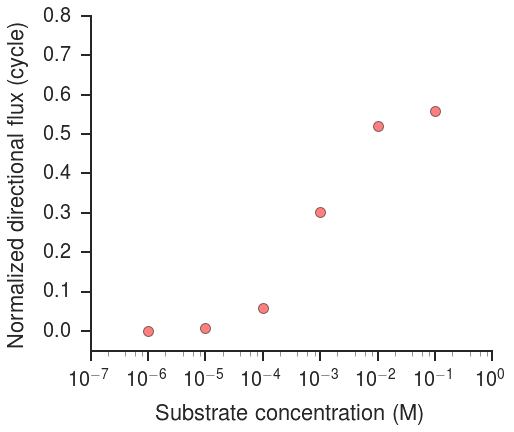

In [27]:
plot_flux_vs_concentration(df, color='red', ymin=-0.05, ymax=0.8)

In [115]:
for concentration in np.arange(-6, 0, 1):
    tmp = return_concentration_slice(df, concentration)
    print(tmp.sort('Directional flux').head(1))

     Concentration  Directional flux  Driven flux        File  \
187             -6         -0.203411     0.307339  chi2ASP124   

     Intersurface flux  Max load  Max power ResID  
187           0.057534  -0.00002   0.000002   124  
      Concentration  Directional flux  Driven flux        File  \
1002             -5         -2.011592     3.035412  chi2ASP124   

      Intersurface flux  Max load  Max power ResID  
1002            0.56942  -0.00003   0.000029   124  
      Concentration  Directional flux  Driven flux        File  \
1817             -4        -18.242405    27.525379  chi2ASP124   

      Intersurface flux  Max load  Max power ResID  
1817           5.163283  -0.00003   0.000274   124  
      Concentration  Directional flux  Driven flux        File  \
2632             -3         -94.39664   142.436593  chi2ASP124   

      Intersurface flux  Max load  Max power ResID  
2632          26.716891  -0.00003   0.001423   124  
      Concentration  Directional flux  Driven fl

/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [116]:
name = 'chi2ASP124'
all_fluxes = []
all_catalytic_rates = []

for concentration in np.arange(-6, 0, 1):
    flux = []
    catalytic_rates = []
    for catalytic_rate in np.arange(0.3, 312, 20):
        this = simulation(data_source='hiv_md_data')
        this.name = name
        this.cSubstrate = 10**concentration
        this.catalytic_rate = catalytic_rate
        this.simulate()
        flux.append(np.mean(this.flux_u + this.flux_b))
        catalytic_rates.append(catalytic_rate)
        del this
    all_fluxes.append(flux)
    all_catalytic_rates.append(catalytic_rates)

In [5]:
hiv_quick_scan = pd.DataFrame()
name = 'chi2ASP124'
calculation = True
if calculation:
    for concentration in np.arange(-6, 0, 0.1):
        print('concentration = {}'.format(concentration))
        for catalytic_rate in np.arange(0.3, 500, 20):
            this = simulation(data_source='hiv_md_data')
            this.name = name
            this.cSubstrate = 10**concentration
            this.catalytic_rate = catalytic_rate
            this.simulate()

            hiv_quick_scan = hiv_quick_scan.append(pd.DataFrame({'Concentration': concentration,
                                        'Directional flux': -1.0 * np.mean(this.flux_u + this.flux_b),
                                        'File': name,
                                        'k_cat': catalytic_rate,
                                        'Ratio' : -1.0 * np.mean(this.flux_u + this.flux_b) / catalytic_rate,
                                        }, index=[0]), ignore_index=True)
            hiv_quick_scan.to_pickle('hiv-quick-scan.pickle')

concentration = -6.0
concentration = -5.9
concentration = -5.800000000000001
concentration = -5.700000000000001
concentration = -5.600000000000001
concentration = -5.500000000000002
concentration = -5.400000000000002
concentration = -5.3000000000000025
concentration = -5.200000000000003
concentration = -5.100000000000003
concentration = -5.0000000000000036
concentration = -4.900000000000004
concentration = -4.800000000000004
concentration = -4.700000000000005
concentration = -4.600000000000005
concentration = -4.500000000000005
concentration = -4.400000000000006
concentration = -4.300000000000006
concentration = -4.200000000000006
concentration = -4.100000000000007
concentration = -4.000000000000007
concentration = -3.9000000000000075
concentration = -3.800000000000008
concentration = -3.700000000000008
concentration = -3.6000000000000085
concentration = -3.500000000000009
concentration = -3.4000000000000092
concentration = -3.3000000000000096
concentration = -3.20000000000001
concentr

In [118]:
hiv_quick_scan

,Concentration,Directional flux,File,Ratio,k_cat
0,-6,0.000491,chi2ASP124,0.001637,0.3
1,-6,0.019127,chi2ASP124,0.000942,20.3
2,-6,0.037998,chi2ASP124,0.000943,40.3
3,-6,0.055232,chi2ASP124,0.000916,60.3
4,-6,0.070937,chi2ASP124,0.000883,80.3
5,-6,0.086546,chi2ASP124,0.000863,100.3
6,-6,0.101099,chi2ASP124,0.000840,120.3
7,-6,0.114204,chi2ASP124,0.000814,140.3
8,-6,0.126002,chi2ASP124,0.000786,160.3
9,-6,0.138134,chi2ASP124,0.000766,180.3


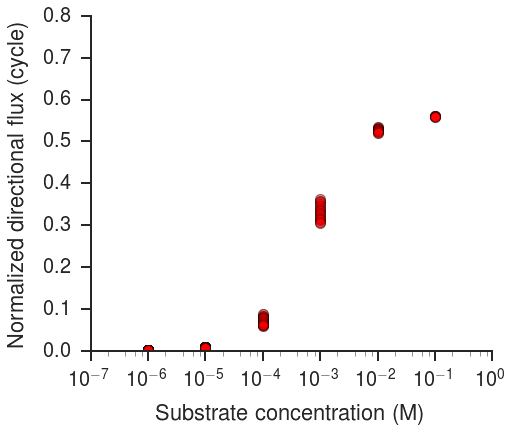

In [131]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax = plt.subplot(gs[0, 0])

concentrations = []
ratio = []
for concentration in np.unique(hiv_quick_scan['Concentration'].values):
    tmp = return_concentration_slice(hiv_quick_scan, concentration)
    concentrations.append(10**concentration)
    ratio.append(tmp['Ratio'])
    
    cmap = sns.cubehelix_palette(len(ratio))
#     for point in ratio:
#         ax.scatter(concentrations[point], ratio[point], 'o', markersize=10, 
#             markeredgecolor='k', markeredgewidth=1.0, alpha=0.2, mfc=cmap[point])
    ax.plot(concentrations, ratio, 'o', markersize=10, 
            markeredgecolor='k', markeredgewidth=1.0, alpha=0.2, mfc='red')


xmin=10**-7
xmax=10**0
# ymin=0
# ymax=0.8
    
ax.set_xlabel('Substrate concentration (M)')
ax.set_ylabel('Normalized directional flux (cycle)')
ax.set_xscale('log')
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
aesthetics.paper_plot(fig)

In [136]:
def return_catalytic_slice(df, cat):
    tmp = df[np.round(df['k_cat'], 1) ==  np.round(cat, 1)]
    return tmp

In [137]:
return_catalytic_slice(hiv_quick_scan, 0.3)

,Concentration,Directional flux,File,Ratio,k_cat
0,-6,0.000491,chi2ASP124,0.001637,0.3
16,-5,0.002515,chi2ASP124,0.008382,0.3
32,-4,0.026306,chi2ASP124,0.087686,0.3
48,-3,0.108991,chi2ASP124,0.363303,0.3
64,-2,0.160144,chi2ASP124,0.533812,0.3
80,-1,0.168481,chi2ASP124,0.561602,0.3


/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/dslochower/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


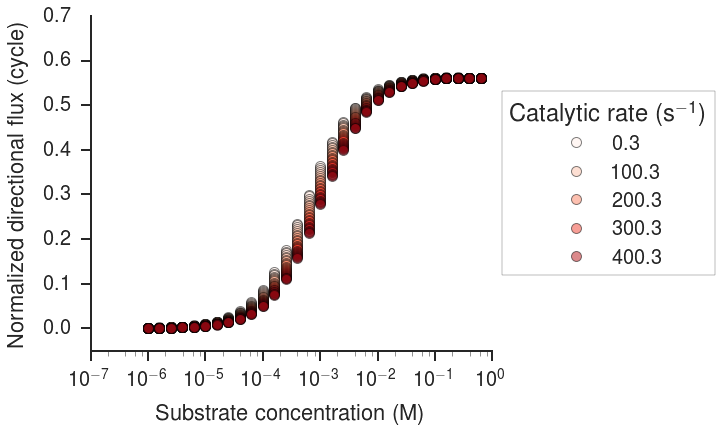

In [172]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax = plt.subplot(gs[0, 0])

concentrations = []
ratio = []
k_cats = np.unique(hiv_quick_scan['k_cat'].values)
cmap = sns.color_palette('Reds', len(k_cats))
for catalytic_rate in k_cats:
    tmp = return_catalytic_slice(hiv_quick_scan, catalytic_rate)
    concentrations = [10**i for i in tmp['Concentration'].values]
    ratio = tmp['Ratio'].values
    
    
    if catalytic_rate in k_cats[::5]:

        ax.plot(concentrations, ratio, 'o', markersize=10, 
                markeredgecolor='k', markeredgewidth=1.0, alpha=0.5, mfc=cmap[np.where(k_cats==catalytic_rate)[0]],
               label='{}'.format(catalytic_rate))
    else:
        ax.plot(concentrations, ratio, 'o', markersize=10, 
                markeredgecolor='k', markeredgewidth=1.0, alpha=0.5, mfc=cmap[np.where(k_cats==catalytic_rate)[0]])

xmin=10**-7
xmax=10**0
ymin=-0.05
ymax=0.7
    
ax.set_xlabel('Substrate concentration (M)')
ax.set_ylabel('Normalized directional flux (cycle)')
ax.set_xscale('log')
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, title='Catalytic rate (s$^{{-1}}$)')
aesthetics.paper_plot(fig)

In [171]:
hiv_quick_scan

,Concentration,Directional flux,File,Ratio,k_cat
0,-6.0,-0.000037,chi2ASP124,-0.000123,0.3
1,-6.0,0.019449,chi2ASP124,0.000958,20.3
2,-6.0,0.037236,chi2ASP124,0.000924,40.3
3,-6.0,0.055923,chi2ASP124,0.000927,60.3
4,-6.0,0.071492,chi2ASP124,0.000890,80.3
5,-6.0,0.086099,chi2ASP124,0.000858,100.3
6,-6.0,0.100705,chi2ASP124,0.000837,120.3
7,-6.0,0.114133,chi2ASP124,0.000813,140.3
8,-6.0,0.126361,chi2ASP124,0.000788,160.3
9,-6.0,0.138538,chi2ASP124,0.000768,180.3


/home/dslochower/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


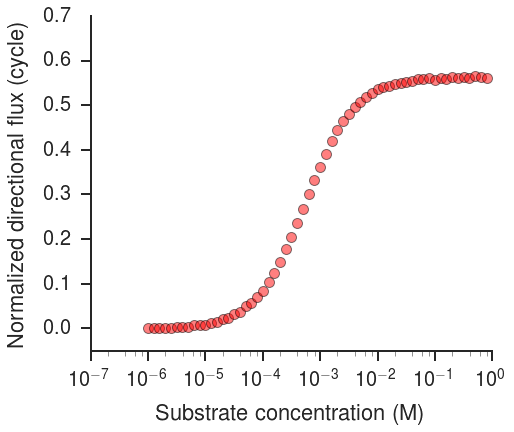

In [177]:
fig = plt.figure(figsize=(6 * 1.2, 6))
gs = GridSpec(1, 1, wspace=0.2, hspace=0.5)
ax = plt.subplot(gs[0, 0])

concentrations = []
ratio = []

catalytic_rate = 0.3

tmp = return_catalytic_slice(hiv_quick_scan, catalytic_rate)
concentrations = [10**i for i in tmp['Concentration'].values]
ratio = tmp['Ratio'].values


ax.plot(concentrations, ratio, 'o', markersize=10, 
        markeredgecolor='k', markeredgewidth=1.0, alpha=0.5, mfc='red')

xmin=10**-7
xmax=10**0
ymin=-0.05
ymax=0.7
    
ax.set_xlabel('Substrate concentration (M)')
ax.set_ylabel('Normalized directional flux (cycle)')
ax.set_xscale('log')
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True, title='Catalytic rate (s$^{{-1}}$)')
aesthetics.paper_plot(fig)